## Introduction

This script demonstrates how you can use a RNN-based model to detect anomalies in timeseries data.

## Setup

In [1]:
import json
import os
import random

import numpy as np
import pandas as pd
import sklearn
from celluloid import Camera
from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tqdm.notebook import tqdm
from evaluator import evaluate, compute_threshold
from dataloader import loader

# from sklearn.metrics import confusion_matrix

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

2023-02-12 02:32:12.860959: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


# Load the data

We will use the SMAP data sets for training and testing.

You can find raw data in https://s3-us-west-2.amazonaws.com/telemanom/data.ziphttps://s3-us-west-2.amazonaws.com/telemanom/data.zip

I used preprocessed datasets with 25 dimensions.

You can find preprocessed data in https://drive.google.com/drive/folders/1gisthCoE-RrKJ0j3KPV7xiibhHWT9qRmhttps://drive.google.com/drive/folders/1gisthCoE-RrKJ0j3KPV7xiibhHWT9qRm

In [2]:
df_train, df_test, df_test_label = loader(dataset="UCR")
print(df_train.shape)

## Visualize the data
### Timeseries data without anomalies

We will use the following data for training.

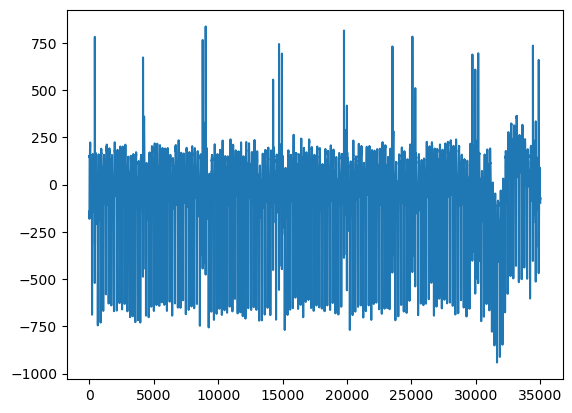

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True)
df_train.plot(legend=False, ax=ax, subplots=True)
plt.show()

### Timeseries data with anomalies

We will use the following data for testing and see if the sudden jump up in the
data is detected as an anomaly.

  0%|          | 0/1 [00:00<?, ?it/s]

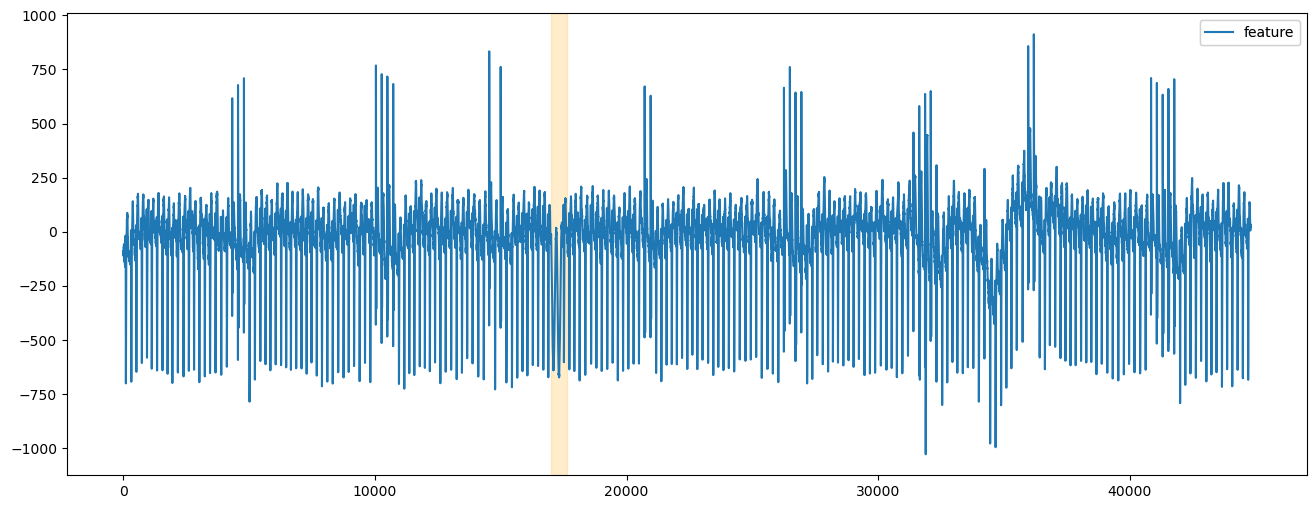

In [5]:
def plot_sensor(df_test, df_test_label, save_path="./UCR.gif"):
    fig = plt.figure(figsize=(16, 6))
    ## 에니메이션 만들기
    camera = Camera(fig)
    ax = fig.add_subplot(111)

    ## 불량 구간 탐색 데이터
    labels = df_test_label["label"].values.tolist()
    idxs = df_test.index

    for var_name in tqdm([item for item in df_test.columns if "feature" in item]):
        ## 센서별로 사진 찍기
        df_test[var_name].plot(ax=ax)
        ax.legend([var_name], loc="upper right")

        ## 고장구간 표시
        temp_start = idxs[0]
        temp_date = idxs[0]
        temp_label = labels[0]

        for xc, value in zip(idxs, labels):
            if temp_label != value:
                if temp_label == True:
                    ax.axvspan(temp_start, temp_date, alpha=0.2, color="orange")
                temp_start = xc
                temp_label = value
            temp_date = xc

        if temp_label == True:
            ax.axvspan(temp_start, xc, alpha=0.2, color="orange")
        ## 카메라 찍기
        camera.snap()

    animation = camera.animate(500, blit=True)
    # .gif 파일로 저장하면 끝!
    animation.save(save_path, dpi=100, savefig_kwargs={"pad_inches": "tight"})


plot_sensor(df_test, df_test_label)

## Prepare training data


In [6]:
from sklearn.preprocessing import StandardScaler

# Skip data normalization because SMAP datas were already normalized.
df_train = df_train.fillna(method="ffill")
scaler = StandardScaler()
scaler.fit(df_train)
df_training_value = pd.DataFrame(scaler.transform(df_train))
print("Number of training samples:", len(df_training_value))

Number of training samples: 35000


### Create sequences
Create sequences combining `TIME_STEPS` contiguous data values from the
training data.

In [7]:
TIME_STEPS = 100

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


x_train = create_sequences(df_training_value.values)
# x_valid = create_sequences(df_validating_value.values)
print("Training input shape: ", x_train.shape)
# print("Validating input shape: ", x_valid.shape)
NUM_OF_FEATURES = x_train.shape[-1]

Training input shape:  (34901, 100, 1)


## Build a model

We will build a convolutional reconstruction autoencoder model. The model will
take input of shape `(batch_size, sequence_length, num_features)` and return
output of the same shape. In this case, `sequence_length` is 288 and
`num_features` is 1.

In [8]:
model = keras.Sequential(
    [
        layers.InputLayer((x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(filters=32, kernel_size=7, padding="same", strides=2, activation="relu"),
        layers.Dropout(rate=0.2),
        layers.Conv1D(filters=16, kernel_size=7, padding="same", strides=2, activation="relu"),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=x_train.shape[2], kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 50, 32)            256       
_________________________________________________________________
dropout (Dropout)            (None, 50, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 25, 16)            3600      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 50, 16)            1808      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 16)            0         
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 100, 32)           3616      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 100, 1)            2

2023-02-12 02:32:14.496046: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-02-12 02:32:14.510763: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:1f:00.0 name: NVIDIA GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 82 deviceMemorySize: 23.70GiB deviceMemoryBandwidth: 871.81GiB/s
2023-02-12 02:32:14.510797: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-02-12 02:32:14.513021: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-02-12 02:32:14.513096: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2023-02-12 02:32:14.513744: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcu

## Train the model

Please note that we are using `x_train` as both the input and the target
since this is a reconstruction model.

In [9]:
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.2,
    callbacks=[keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")],
)

2023-02-12 02:32:15.142486: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-02-12 02:32:15.145042: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2900000000 Hz


Epoch 1/50


2023-02-12 02:32:15.573565: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2023-02-12 02:32:16.301919: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8201
2023-02-12 02:32:17.246887: E tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-02-12 02:32:17.246923: W tensorflow/stream_executor/gpu/asm_compiler.cc:56] Couldn't invoke ptxas --version
2023-02-12 02:32:17.247552: E tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-02-12 02:32:17.255116: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-02-12 02:32:17.260237: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully ope

219/219 [==============================] - 5s 8ms/step - loss: 0.1079 - val_loss: 0.0246
Epoch 2/50
219/219 [==============================] - 1s 6ms/step - loss: 0.0198 - val_loss: 0.0144
Epoch 3/50
219/219 [==============================] - 1s 6ms/step - loss: 0.0128 - val_loss: 0.0174
Epoch 4/50
219/219 [==============================] - 1s 7ms/step - loss: 0.0099 - val_loss: 0.0274
Epoch 5/50
219/219 [==============================] - 1s 7ms/step - loss: 0.0086 - val_loss: 0.0332
Epoch 6/50
219/219 [==============================] - 1s 7ms/step - loss: 0.0077 - val_loss: 0.0322
Epoch 7/50
219/219 [==============================] - 1s 7ms/step - loss: 0.0070 - val_loss: 0.0352


Let's plot training and validation loss to see how the training went.

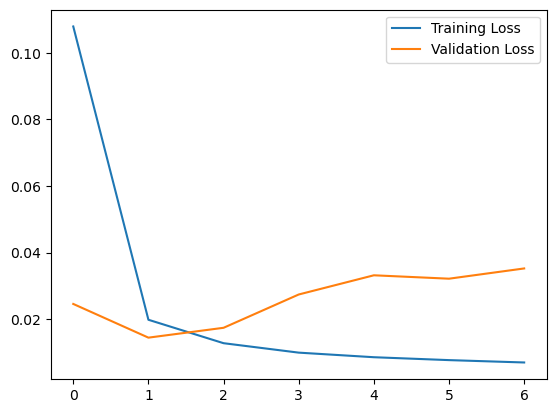

In [10]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

## Detecting anomalies
### We could set threshold my using train loss, and detect which points are anomalies

In [11]:
x_train_pred = model.predict(x_train)

In [12]:
# print(f'abs mean threshold: {compute_threshold(x_train, x_train_pred, option="abs_mean")}')
# print(f'abs median threshold: {compute_threshold(x_train, x_train_pred, option="abs_median")}')
# print(f'square mean threshold: {compute_threshold(x_train, x_train_pred, option="square_mean")}')
# print(f'square median threshold: {compute_threshold(x_train, x_train_pred, option="square_median")}')

# Choose the lowest loss of the anomaly datas((# of anomalies)th) as threshold by using rank option
threshold = compute_threshold(x_train, x_train_pred, option="abs_max")
print(f'rank threshold: {threshold}')

rank threshold: 0.4440653324127197


### Prepare test data

In [13]:
df_test_value = pd.DataFrame(scaler.transform(df_test))

# Create sequences from test values.
x_test = create_sequences(df_test_value.values)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)

# Detect all the samples which are anomalies.
# anomalies = test_mae_loss > threshold
anomalies = np.sum(test_mae_loss, axis=1) > threshold

Test input shape:  (44696, 100, 1)


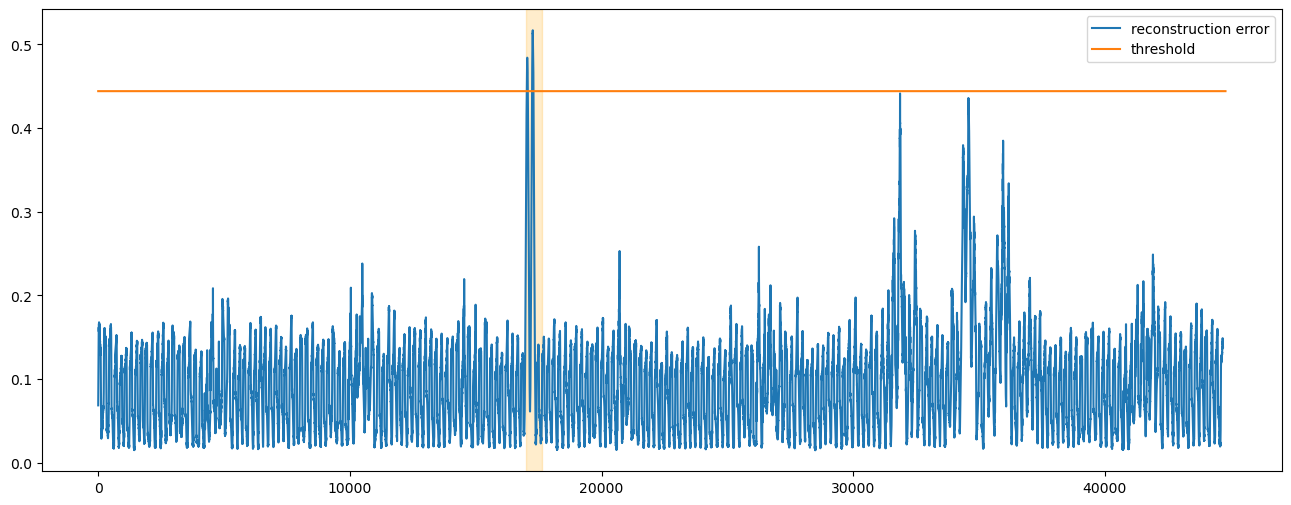

In [14]:
fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(111)

labels = df_test_label['label'].values.tolist()
dates = df_test.index


pd.DataFrame(np.sum(test_mae_loss, axis=1)).plot(ax=ax)
pd.DataFrame([threshold]*len(df_test)).plot(ax=ax)
ax.legend(["reconstruction error", "threshold"], loc="upper right")


temp_start = dates[0]
temp_date = dates[0]
temp_label = labels[0]

for xc, value in zip(dates, labels):
    if temp_label != value:
        if temp_label==True:
            ax.axvspan(temp_start, temp_date, alpha=0.2, color="orange")
        temp_start = xc
        temp_label = value
    temp_date = xc
if temp_label==True:
    ax.axvspan(temp_start, xc, alpha=0.2, color="orange")


## Predict & Evaluation


## #1 Set threshold by using evaluator

In [15]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalies = np.sum(test_mae_loss, axis=1) > threshold
print("Number of anomaly samples: ", np.sum(anomalies))

anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.any(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)
print("Number of anomalous samples: ", len(anomalous_data_indices))

Number of anomaly samples:  100
Number of anomalous samples:  296


In [16]:
from sklearn.metrics import classification_report

test_pred = np.zeros(len(df_test))
test_label = df_test_label['label']
test_pred[anomalous_data_indices] = 1

accuracy = (np.sum(test_pred == test_label)) / len(test_label)
precision = (np.sum(test_pred * test_label)) / np.sum(test_pred)
recall = (np.sum(test_pred * test_label)) / np.sum(test_label)
f1 = 2 * (precision * recall) / (precision + recall + 1e-7)

print(f"accuracy: {accuracy*100:.2f}%")
print(f"precision: {precision*100:.2f}%")
print(f"recall: {recall*100:.2f}%")
print(f"f1: {f1*100:.2f}%")

accuracy: 99.27%
precision: 100.00%
recall: 47.67%
f1: 64.56%


### #2 we could find the threshold with highest f1 score by calculating all cases 


In [17]:
from evaluator import evaluate

scores = evaluate(x_test, x_test_pred, df_test_label['label'], n=10, scoring='abs_mean')

In [18]:
print("f1:",np.max(scores['f1']))

f1: 0.02740693067715209
